# PART A
# PROJECT OBJECTIVE: To build a face detection system.

In [1]:
import os
import cv2
import keras
import pandas             as pd
import matplotlib.pyplot  as plt
import numpy              as np
import tensorflow         as tf
import pickle

from zipfile import ZipFile
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

UsageError: Line magic function `%tensorflow_version` not found.


In [2]:
data = np.load('images.npy', allow_pickle = True)
data.shape

(409, 2)

In [3]:
X = data[:,0]
Y = data[:,1]
print(X.shape, Y.shape)

(409,) (409,)


In [4]:
data[0], data[0][0], data[0][1]

(array([array([[[42, 37, 34],
                [56, 51, 48],
                [71, 66, 63],
                ...,
                [23, 33, 34],
                [26, 36, 37],
                [28, 38, 39]],
 
               [[40, 35, 32],
                [51, 46, 43],
                [64, 59, 56],
                ...,
                [27, 36, 35],
                [24, 33, 32],
                [26, 35, 34]],
 
               [[43, 38, 35],
                [51, 46, 43],
                [61, 56, 53],
                ...,
                [28, 30, 27],
                [33, 35, 32],
                [35, 37, 34]],
 
               ...,
 
               [[56, 47, 40],
                [57, 48, 41],
                [61, 52, 45],
                ...,
                [67, 48, 42],
                [55, 35, 28],
                [60, 40, 33]],
 
               [[53, 44, 37],
                [54, 45, 38],
                [57, 48, 41],
                ...,
                [59, 40, 34],
                [60, 

In [12]:
#Unifying the shape
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
ALPHA = 1
Y = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
       continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        Y[index][y1:y2, x1:x2] = 1

In [13]:
X.shape

(409, 224, 224, 3)

In [14]:
Y.shape

(409, 224, 224)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=9/409)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(400, 224, 224, 3) (9, 224, 224, 3) (400, 224, 224) (9, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The original image array [[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]


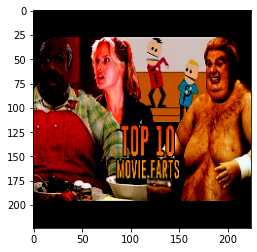

In [16]:
from matplotlib import pyplot
import random

n = random.randint(0,400) 
print("The original image array",X_train[n])
pyplot.imshow(X_train[n])

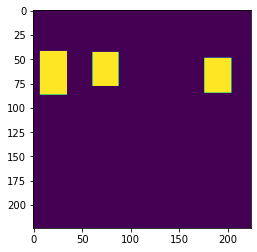

In [17]:
#The masked image
pyplot.imshow(y_train[n])

In [18]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model
import tensorflow as tf

HEIGHT_CELLS = 28
WIDTH_CELLS = 28
BATCH_SIZE = 1

In [19]:
model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1, weights="imagenet")
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [20]:
def create_model(trainable=False):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
        
    block00 = model.layers[0].input
    block01 = model.get_layer("conv_pw_1_relu").output
    block02 = model.get_layer("conv_pw_2_relu").output
    block03 = model.get_layer("conv_pw_3_relu").output
    block05 = model.get_layer("conv_pw_5_relu").output
    block11 = model.get_layer("conv_pw_11_relu").output
    block13 = model.get_layer("conv_pw_13_relu").output

    decoderBlock = Concatenate()([UpSampling2D()(block13), block11])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block05])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block03])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block01])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block00])

    decoderBlock = Conv2D(1, kernel_size=1, activation="sigmoid")(decoderBlock)
    decoderBlock = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(decoderBlock)

    return Model(inputs=model.input, outputs=decoderBlock) 

In [21]:
model = create_model()

# Print summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                             

In [22]:
def dice_coeff(y_true, y_pred):
    nume = 2 * tf.reduce_sum(y_true * y_pred)
    deno = tf.reduce_sum(y_true + y_pred)

    return nume/(deno + tf.keras.backend.epsilon())

In [23]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss_function(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coeff(y_true, y_pred) + epsilon())

In [24]:
optimizer = tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss_function, optimizer = optimizer, metrics=[dice_coeff])

C:\Users\vrooky-montzo\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor="val_loss", patience=5)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)

In [26]:
model.fit(X_train,y_train,epochs = 5,verbose=1,batch_size=3,callbacks=[checkpoint,reduce_lr,stop])

Epoch 1/5
134/134 [==============================] - ETA: 0s - loss: 1.9669 - dice_coeff: 0.2472

KeyError: 'Failed to format this callback filepath: "model-{val_loss:.2f}.h5". Reason: \'val_loss\''

In [27]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=1, batch_size=32, verbose=1)

ResourceExhaustedError: Graph execution error:

Detected at node 'model/concatenate_3/concat' defined at (most recent call last):
    File "C:\Users\vrooky-montzo\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\vrooky-montzo\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\vrooky-montzo\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\vrooky-montzo\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\vrooky-montzo\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\vrooky-montzo\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\vrooky-montzo\anaconda3\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Users\vrooky-montzo\anaconda3\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Users\vrooky-montzo\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\vrooky-montzo\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "C:\Users\vrooky-montzo\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "C:\Users\vrooky-montzo\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "C:\Users\vrooky-montzo\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "C:\Users\vrooky-montzo\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\vrooky-montzo\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\vrooky-montzo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "C:\Users\vrooky-montzo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "C:\Users\vrooky-montzo\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\vrooky-montzo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\vrooky-montzo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\vrooky-montzo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\VROOKY~1\AppData\Local\Temp/ipykernel_29324/4214158774.py", line 1, in <module>
      model.fit(X_train,y_train,epochs = 5,verbose=1,batch_size=3,callbacks=[checkpoint,reduce_lr,stop])
    File "C:\Users\vrooky-montzo\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\vrooky-montzo\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\vrooky-montzo\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\vrooky-montzo\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\vrooky-montzo\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\vrooky-montzo\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\vrooky-montzo\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\vrooky-montzo\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\vrooky-montzo\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\vrooky-montzo\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "C:\Users\vrooky-montzo\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\vrooky-montzo\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\vrooky-montzo\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\vrooky-montzo\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\vrooky-montzo\AppData\Roaming\Python\Python39\site-packages\keras\layers\merge.py", line 183, in call
      return self._merge_function(inputs)
    File "C:\Users\vrooky-montzo\AppData\Roaming\Python\Python39\site-packages\keras\layers\merge.py", line 531, in _merge_function
      return backend.concatenate(inputs, axis=self.axis)
    File "C:\Users\vrooky-montzo\AppData\Roaming\Python\Python39\site-packages\keras\backend.py", line 3313, in concatenate
      return tf.concat([to_dense(x) for x in tensors], axis)
Node: 'model/concatenate_3/concat'
OOM when allocating tensor with shape[32,112,112,1984] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node model/concatenate_3/concat}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_6229]

In [ ]:
3.Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image. 

In [ ]:
#predicted mask
Y_pred = model.predict(X_test)
plt.imshow(Y_pred[3])

In [ ]:
#original test image
plt.imshow(X_test[3])

In [ ]:
sample_image = X_test[3]
image = cv2.resize(sample_image, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([feat_scaled]))[0] > 0.2), (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

plt.imshow(out_image)